# Product Analysis with KMeans Clustering
---
## Overview
-
-

### Imports

In [1]:
# Imports needed for clustering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

### Load Subset of Cleaned Data

In [15]:
# Load in only subset of data, sample size: 50,000
df = pd.read_csv('../data/Clean-ALL_reviews.csv', lineterminator='\n', low_memory=False ).sample(n=50000)
df.head()

author_id  rating  is_recommended  total_feedback_count  \
342344    6773121478       4               1                    47   
841136   25844185304       5               1                     3   
424709    9092607722       4               1                     0   
558695    2556117081       5               1                     5   
1067238      3577662       5               1                    29   

         total_neg_feedback_count  total_pos_feedback_count submission_time  \
342344                         28                        19      2021-11-07   
841136                          1                         2      2022-04-27   
424709                          0                         0      2020-11-17   
558695                          1                         4      2022-01-20   
1067238                         5                        24      2018-03-15   

                                               review_text  \
342344   I love noticing smaller pores, plumper skin an...   
841136   I put in the refrigerator & apply it if i’ve h...   
424709   Been using for a week along with Naturiums nia...   
558695   This is truly one of the most important produc...   
1067238  Add me to the list of happy customers. I feel ...   

                                     review_title    skin_tone  ...  \
342344                            Visible Results  lightMedium  ...   
841136                                 Love this!  lightMedium  ...   
424709                moisturizing but not greasy  lightMedium  ...   
558695                 Most effective exfoliator!        light  ...   
1067238  Great product to add for hormone balance         fair  ...   

            brand_name price_usd loves_count reviews_count               size  \
342344    Estée Lauder       195       11269          2410  2x 1.7 oz / 50 mL   
841136          KORRES        52       12229           509    3.38 oz/ 100 mL   
424709         LANEIGE        33      143173          1859     5.0 oz/ 150 mL   
558695    The Ordinary         8      295071          1289        1 oz/ 30 mL   
1067238  HUM Nutrition        26        9393            81        60 Capsules   

        variation_type    variation_value  \
342344            Size  2x 1.7 oz / 50 mL   
841136            Size    3.38 oz/ 100 mL   
424709            Size     5.0 oz/ 150 mL   
558695            Size        1 oz/ 30 mL   
1067238  Not specified      Not specified   

                                               ingredients  primary_category  \
342344   ['Water\\Aqua\\Eau, Bifida Ferment Lysate, Peg...          Skincare   
841136   ['Aqua/Water/Eau, Yogurt, Glycerin, Hexyldecyl...          Skincare   
424709   ['Water, Butylene Glycol, Glycerin, Limnanthes...          Skincare   
558695   ['Aqua (Water), Lactic Acid, Glycerin, Pentyle...          Skincare   
1067238  ['Chasteberry Tree Extract, Dong Quai, Maltode...          Skincare   

        secondary_category  
342344          Treatments  
841136               Masks  
424709        Moisturizers  
558695          Treatments  
1067238           Wellness  

[5 rows x 25 columns]

### Preprocessing

In [16]:
# Define the categorical and numeric feature columns to use for Kmeans
cat_cols = ['product_name', 'brand_name', 'skin_type','hair_color','skin_tone', 'variation_value','size','secondary_category']
num_cols = ['price_usd', 'rating','is_recommended','loves_count']


# Preprocess the data using one-hot encoding and standard scaling with Column Transformer
preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])

# Apply the preprocessing and obtain the transformed features
X = preprocessor.fit_transform(df)

## Modeling

### KMeans

#### Searching for Optimal # of Clusters for KMeans

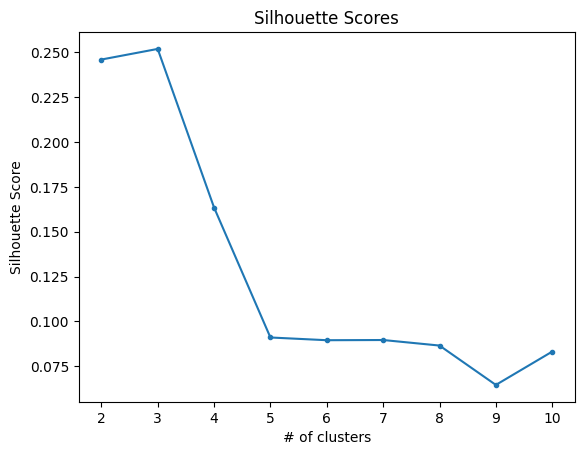

In [17]:
# Create loop that measures silhouette scores to find optimal number of clusters
# Code adapted from lessonn 7.01 kmeans
silhouette_list = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    silhouette_list.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(range(2, 11), silhouette_list, marker = '.')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores');

- According to the Silhouette Score graph shown above, the optimal value for number of clusters is 3 since it achieved the highest silhouette score. 

#### Final KMeans Model

In [18]:
# Instantiate and fit Kmeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the df
df['cluster'] = cluster_labels

# Check out clusters
df.groupby('cluster').mean()

rating  is_recommended  total_feedback_count  \
cluster                                                   
0        2.058321        0.001404              8.057427   
1        4.725990        1.000000              3.226199   
2        4.447352        0.880026              9.619655   

         total_neg_feedback_count  total_pos_feedback_count  price_usd  \
cluster                                                                  
0                        2.752042                  5.305385   49.29977   
1                        0.510185                  2.716013   49.98389   
2                        1.474154                  8.145501   17.13529   

           loves_count  reviews_count  
cluster                                
0         90182.009699    1855.159265  
1         81750.404316    1933.194768  
2        839408.855137    9641.588385

*Description of Skincare Product Clusters (KMeans):*

**Cluster 0**: Products in this cluster have a lower overall rating, averaging 2.05 out of 5. There is a 0% chance of these products being recommended. The average price for these products is around $49.29. These products have the lowest review counts, which could be attributed to their low ratings. It is likely that fewer people are purchasing these products, resulting in fewer reviews being submitted.

**Cluster 1**: This cluster consists of products with the highest overall rating of 4.7 out of 5, and they are 100% likely to be recommended. These products are similar to those in Cluster 2, but the main difference is that they are higher-priced with a average price of $49.98. The low review count could mean that these products arent as frequently most as the more afforable options

**Cluster 2**: The products in this cluster have an average rating of 4.4 out of 5, and there is an 88% likelihood that these products will be recommended. The average price for these products is approximately $17.13. Products in this cluster have the most reviews per product which could indicate that these products have been at Sephora longer and are the most popular.



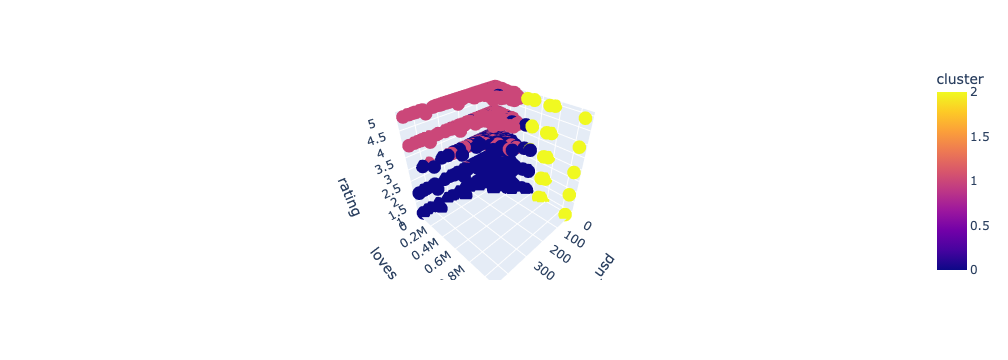

In [19]:
# Plot the clusters based on loves_count, price, and rating
# Code adapted from https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html
px.scatter_3d(df, y='loves_count',x='price_usd',z='rating',color='cluster')

3D Scatterplot Interpretation:

- Cluster 0 : Indigo
- Cluster 1 : Pink
- Cluster 2 : Yellow

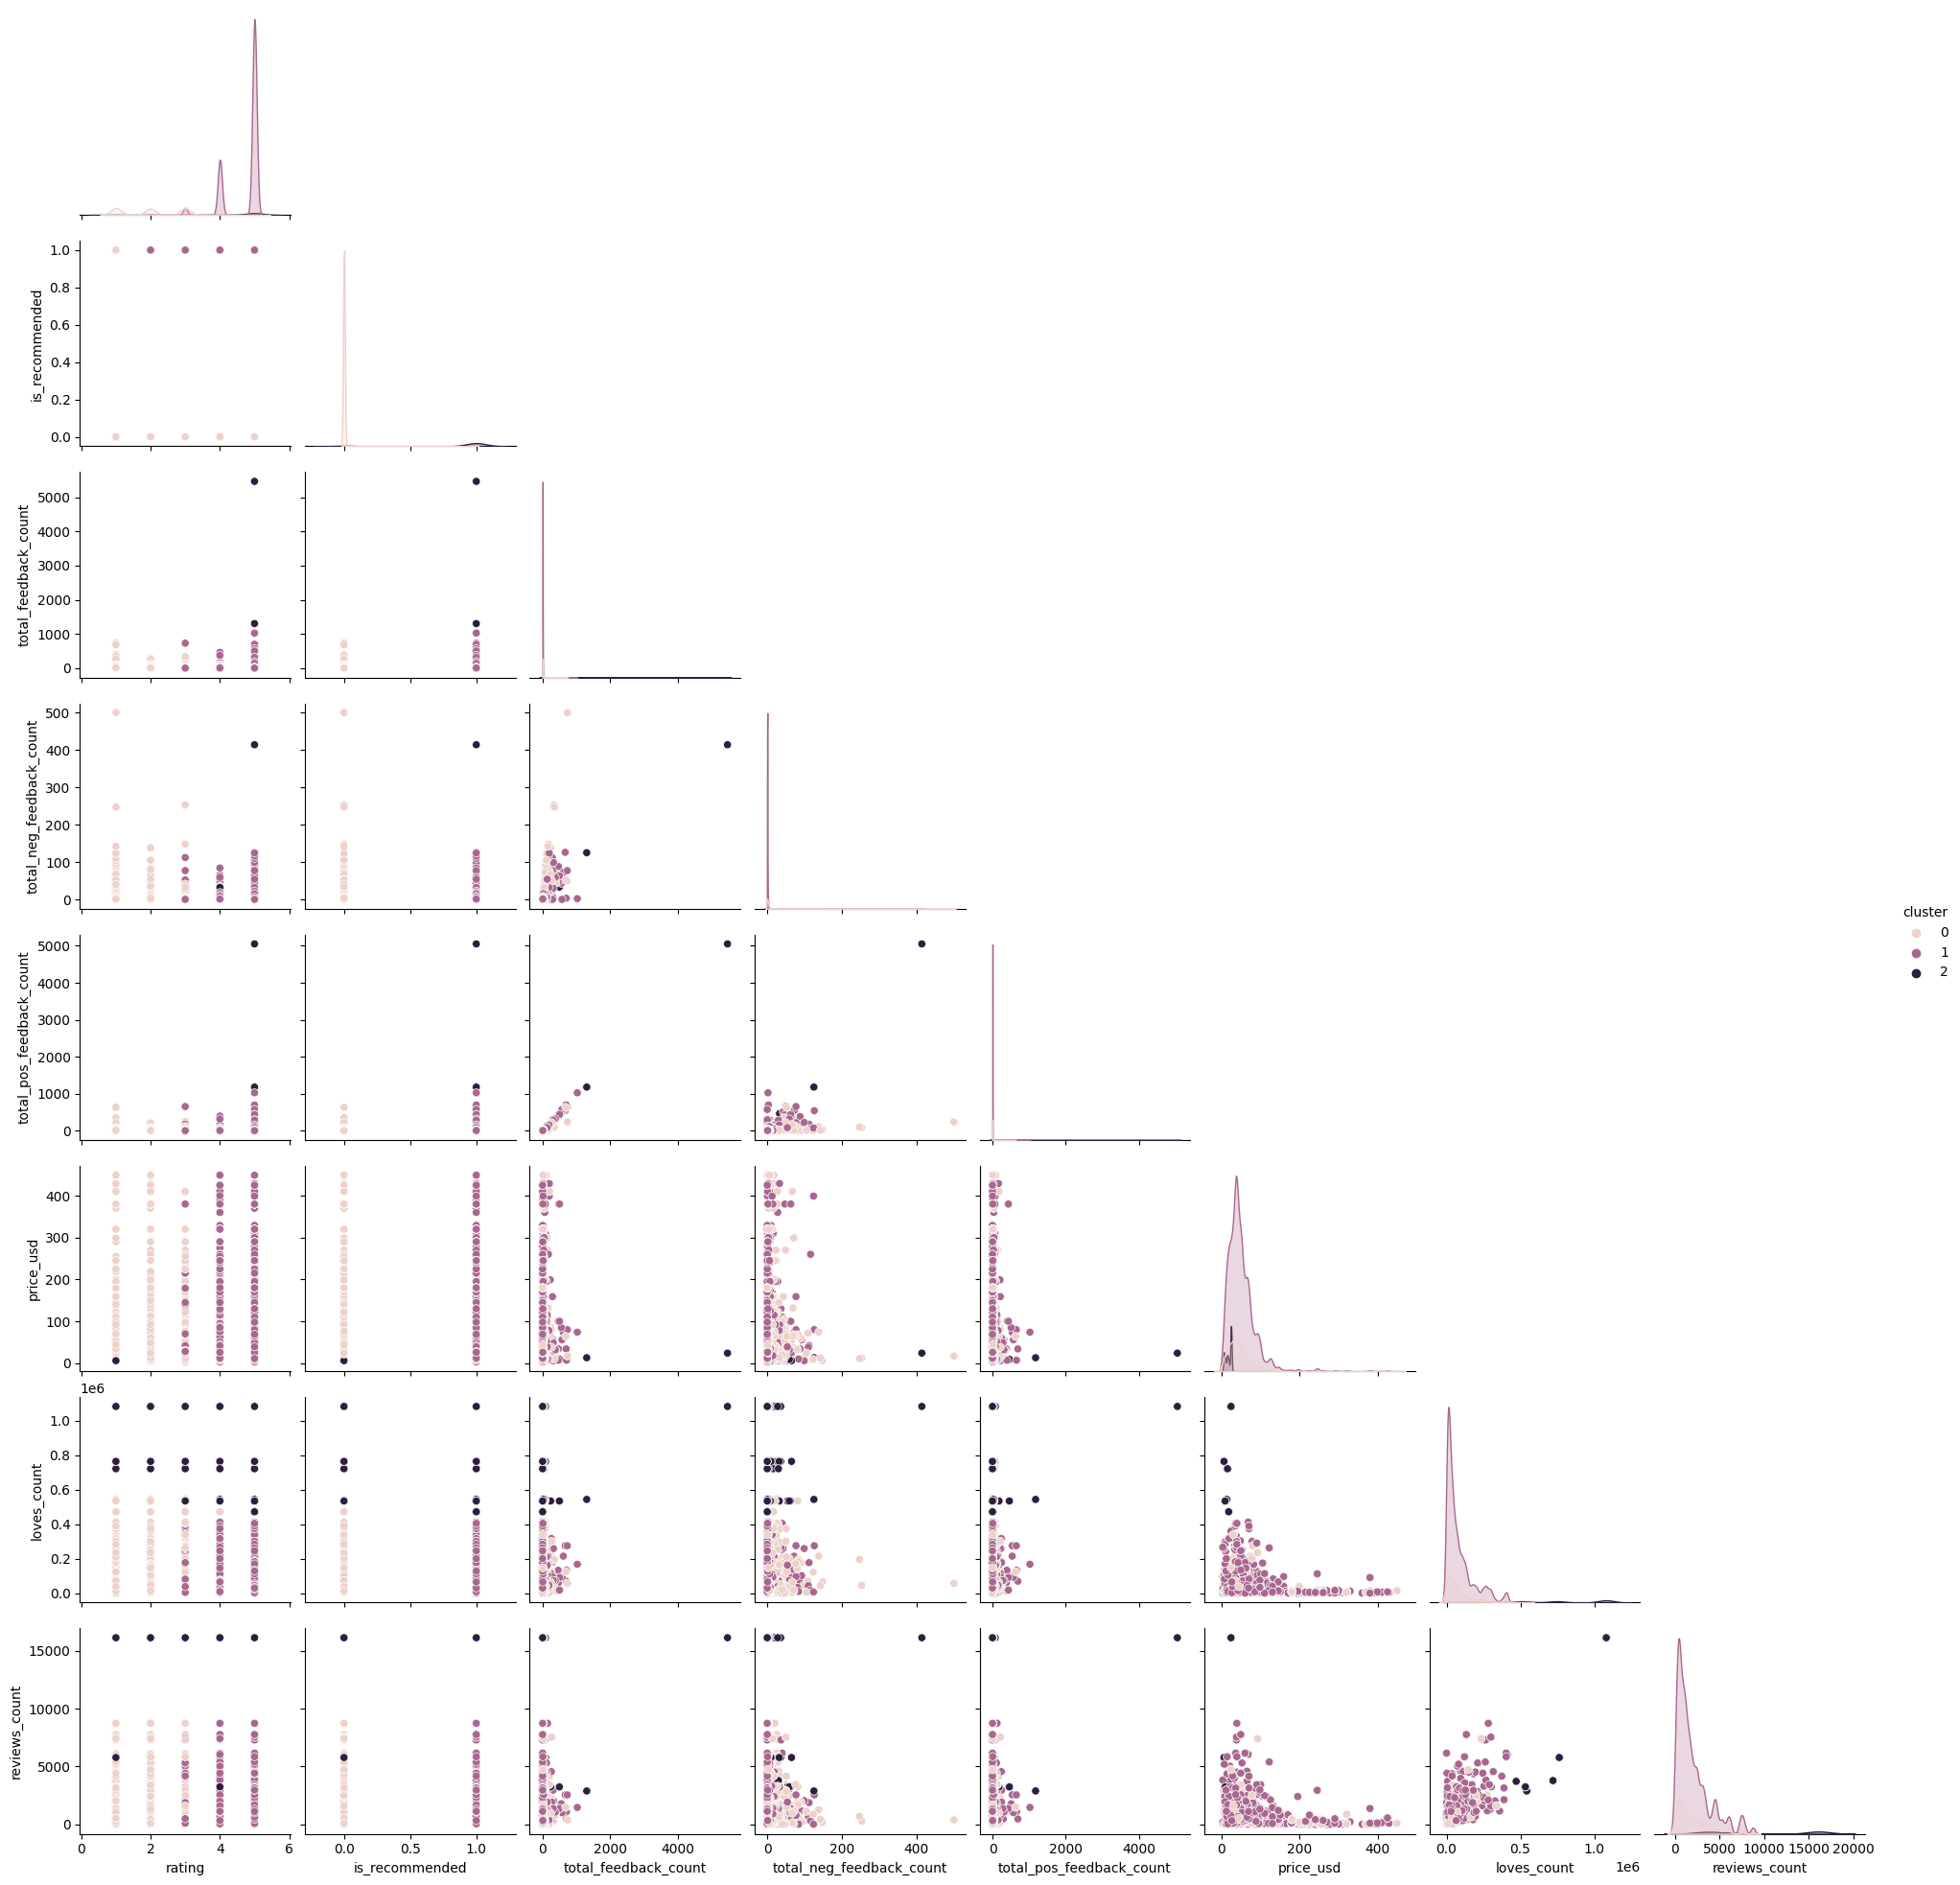

In [20]:
# Additional EDA for the clusters
sns.pairplot(df,
            hue = 'cluster',
            corner = True);